<a href="https://colab.research.google.com/github/HaileyKataram/Qiskit_QFT/blob/main/HAILEY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install -q qiskit qiskit-aer matplotlib

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [13]:
def qft_rotations(qc, n):
    for j in range(n):
        qc.h(j)
        for k in range(2, n - j + 1):
            # control is j+k-1, target is j
            angle = np.pi / (2 ** (k - 1))
            qc.cp(angle, j + k - 1, j)
    return qc

def swap_registers(qc, n):
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    return qc

def qft_circuit(n):
    qc = QuantumCircuit(n)
    qft_rotations(qc, n)
    swap_registers(qc, n)
    qc.name = "QFT"
    return qc

In [15]:
def inverse_qft_circuit(n):
    """Return an n-qubit circuit implementing inverse QFT."""
    qc = QuantumCircuit(n)
    # inverse of swap is swap itself (do swaps first to match reverse order)
    swap_registers(qc, n)
    # inverse rotations: run rotations in reverse order with negative angles
    for j in reversed(range(n)):
        for k in reversed(range(2, n - j + 1)):
            angle = -np.pi / (2 ** (k - 1))
            qc.cp(angle, j + k - 1, j)
        qc.h(j)
    qc.name = "QFT_INV"
    return qc

In [17]:
def run_and_visualize_qft(n, shots=1024):
    """Builds QFT on n qubits, draws circuit (mpl), and measures to show distribution.

    The QFT alone on |x> will produce a state; to produce probabilistic measurement outcomes we
    prepare a computational basis input and then apply QFT and measure.
    """
    # Prepare circuit with n qubits and n classical bits
    qc = QuantumCircuit(n, n)


    # Example: prepare an input state. We'll prepare |1> on the least-significant bit to make it interesting.
    # You can change the preparation to any basis state as needed.
    # Let's prepare state |1> on qubit 0 and zeros elsewhere as a demo.
    qc.x(0)


    # Apply QFT
    qft = qft_circuit(n)
    qc.append(qft.to_instruction(), range(n))


    # Measure
    qc.measure(range(n), range(n))


    # Draw circuit
    print(f"\n--- QFT circuit for n={n} qubits ---")
    display(qc.draw('mpl', idle_wires=False, fold=100))


    # Run simulation
    simulator = AerSimulator()
    compiled = transpile(qc, simulator)
    job = simulator.run(compiled, shots=shots)
    result = job.result()
    counts = result.get_counts()


    print(f"Measurement counts for n={n}:")
    print(counts)
    display(plot_histogram(counts))
    plt.show()


    return qc, counts

In [19]:
def build_phase_unitary(phi):
    u = QuantumCircuit(1)
    u.p(2 * np.pi * phi, 0)
    return u.to_instruction()

def phase_estimation_circuit(num_counting_qubits, phi):
    """Build a phase estimation circuit with a counting register of size num_counting_qubits
    and a single target qubit prepared in the eigenstate |1> of the phase gate.
    The unitary U = P(2*pi*phi) has eigenstate |1> with eigenvalue e^{2pi i phi}.
    """
    # Registers: counting qubits + 1 target qubit
    qc = QuantumCircuit(num_counting_qubits + 1, num_counting_qubits)


    # Prepare counting register in |+> states
    for q in range(num_counting_qubits):
        qc.h(q)


    # Prepare target in eigenstate |1>
    qc.x(num_counting_qubits)


    # Build controlled-U^{2^j} operations
    base_U = build_phase_unitary(phi)
    for j in range(num_counting_qubits):
        # apply controlled-U^{2^{j}} where control is qubit j
        power = 2 ** j
        # controlled phase with angle multiplied by power
        angle = 2 * np.pi * phi * power
        # use cp gate with control j and target being the target qubit
        qc.cp(angle, j, num_counting_qubits)


    # Apply inverse QFT on counting register
    inv_qft = inverse_qft_circuit(num_counting_qubits)
    qc.append(inv_qft.to_instruction(), range(num_counting_qubits))


    # Measure counting register
    qc.measure(range(num_counting_qubits), range(num_counting_qubits))


    qc.name = f"PhaseEst(m={num_counting_qubits}, phi={phi})"
    return qc

In [21]:
def run_phase_estimation_demo(num_counting_qubits=3, phi=1/8, shots=2048):
    """Builds and runs the phase estimation circuit and shows measurement histogram.


    Choose phi such that it can be represented well with num_counting_qubits.
    For phi=1/8 and m=3 counting qubits, the expected measurement is '001' (LSB-first in this construction).
    """
    qc = phase_estimation_circuit(num_counting_qubits, phi)
    print(f"\n--- Phase Estimation circuit (m={num_counting_qubits}, phi={phi}) ---")
    display(qc.draw('mpl', fold=120))


    simulator = AerSimulator()
    compiled = transpile(qc, simulator)
    job = simulator.run(compiled, shots=shots)
    result = job.result()
    counts = result.get_counts()


    print("Measurement counts:")
    print(counts)
    display(plot_histogram(counts))
    plt.show()


    return qc, counts


--- QFT circuit for n=2 qubits ---


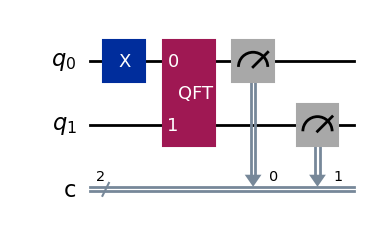

Measurement counts for n=2:
{'01': 267, '10': 243, '00': 243, '11': 271}


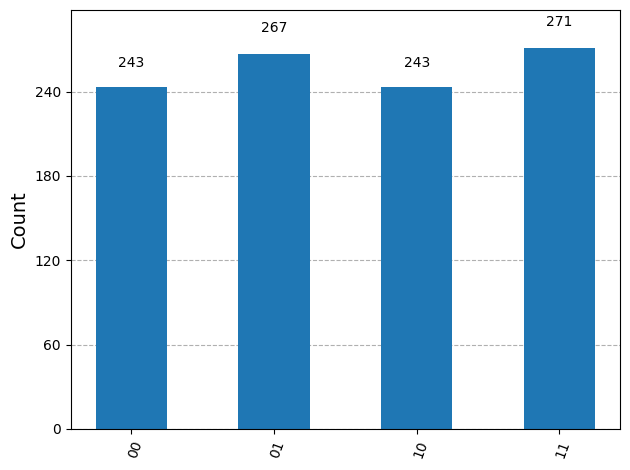


--- QFT circuit for n=3 qubits ---


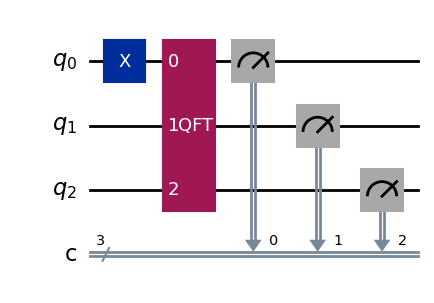

Measurement counts for n=3:
{'100': 153, '001': 113, '110': 124, '000': 144, '010': 141, '101': 111, '011': 122, '111': 116}


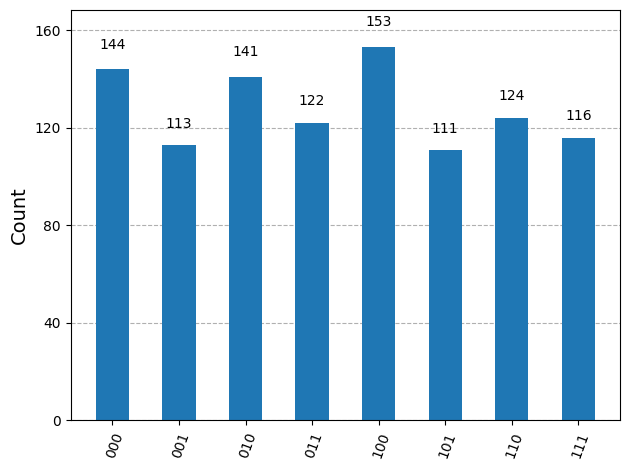


--- QFT circuit for n=4 qubits ---


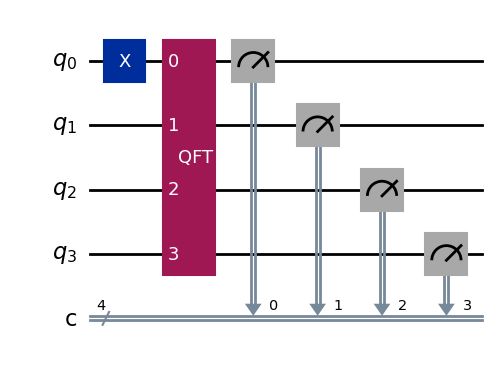

Measurement counts for n=4:
{'1100': 60, '0001': 55, '1110': 50, '1011': 61, '0111': 47, '0011': 55, '1101': 76, '0101': 64, '1001': 65, '0110': 63, '1000': 74, '0000': 66, '0010': 64, '0100': 73, '1010': 76, '1111': 75}


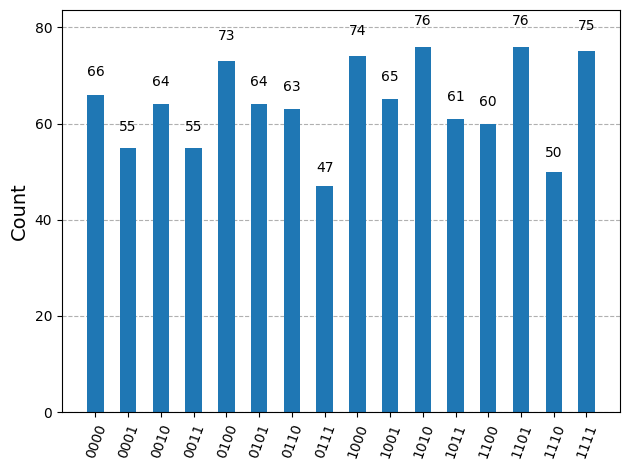


--- Phase Estimation circuit (m=3, phi=0.125) ---


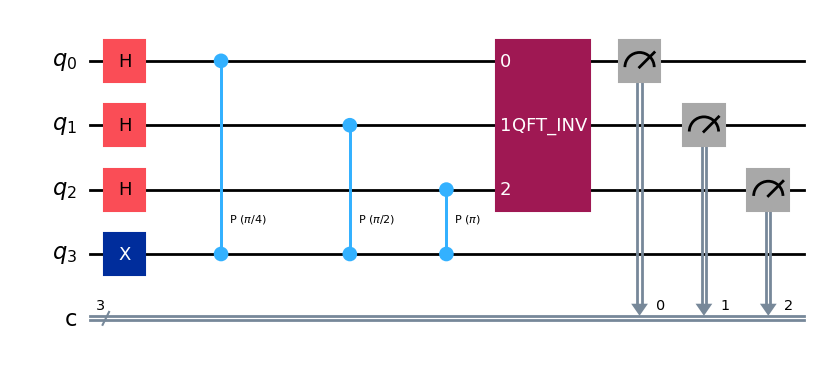

Measurement counts:
{'100': 56, '011': 442, '001': 885, '101': 244, '010': 421}


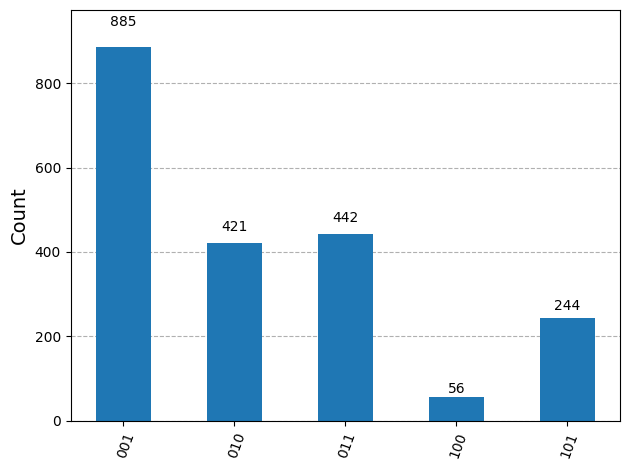

In [23]:
if __name__ == '__main__':
    # Try QFT for 2, 3, and 4 qubits
    run_and_visualize_qft(2)
    run_and_visualize_qft(3)
    run_and_visualize_qft(4)


    # Run phase estimation demo (3 counting qubits, phi=1/8)
    run_phase_estimation_demo(num_counting_qubits=3, phi=1/8)